In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
# loading R packages
library(DESeq2)
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in last
library(ggplot2)
library(rwantshue)
library(RColorBrewer)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

In [259]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [260]:
%%R

#physeq = subset_samples(physeq, Sample!=)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

#ps.merged = subset_samples(ps.merged,row.names(sample_data(ps.merged))!="S_2.5_14")
# Removing soil sample with large Onygenales taxon (Emmonsia) - soil saprotroph, but huge

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
sample_data(ps.merged)
# Cleaning up the sample data table
physeq = ps.merged

In [261]:
%%R
sample.data<-data.frame(sample_data(physeq)) %>%
    dplyr::group_by(Trtmt,Month) %>%
    dplyr::summarize(total=n())
sample.data
# Find out how many of each treatment-month combination we have... 
# Don't want to run it on anything with just one or two samples

Source: local data frame [14 x 3]
Groups: Trtmt

            Trtmt Month total
1           Blank    NA     1
2    Ferrihydrite   2.0     4
3    Ferrihydrite   2.5     9
4    Ferrihydrite   3.0     5
5  Heavy Fraction   2.5     3
6       Kaolinite   2.0     4
7       Kaolinite   2.5     8
8       Kaolinite   3.0     5
9          Quartz   2.0     4
10         Quartz   2.5     9
11         Quartz   3.0     5
12           Soil   2.0     5
13           Soil   2.5     6
14           Soil   3.0     5


In [262]:
%%R
# Creating a matrix with the different combinations of variables for day and amendment
variables = expand.grid(Trtmt = c("Ferrihydrite","Quartz"),
                        Month = c(2, 2.5, 3))
#<-variables[c(1,2,4,5,6,7,8),]
variables

         Trtmt Month
1 Ferrihydrite   2.0
2       Quartz   2.0
3 Ferrihydrite   2.5
4       Quartz   2.5
5 Ferrihydrite   3.0
6       Quartz   3.0


In [263]:
%%R
#run deseq on each subset of factors (day and amendment), return the factors, OTU ID, base mean, log2-fold change, 
# the standard error, and the p value associated with the response.

Dif_Abund = function(Trtmt,Month){
    physeq.pruned <- prune_samples(((sample_data(physeq)$Month == Month) & (sample_data(physeq)$Trtmt == Trtmt)) | ((sample_data(physeq)$Month == Month) & (sample_data(physeq)$Trtmt == "Soil")),physeq)
    physeq.pruned = prune_taxa(taxa_sums(physeq.pruned) > 0, physeq.pruned)
    physeq.pruned = prune_samples(sample_sums(physeq.pruned)>1500, physeq.pruned)
    taxonomy <- data.frame(tax_table(physeq.pruned))
    dseq = phyloseq_to_deseq2(physeq.pruned, ~Trtmt)
    dseq$Trtmt = relevel(dseq$Trtmt,"Soil")
    dseq = DESeq(dseq, quiet = TRUE, fitType = "local")
    results = results(dseq, cooksCutoff=TRUE)
# Change CooksCutoff to stop outliers (FALSE leaves them in)
    results$Month = Month
    results$Trtmt = Trtmt
    results = data.frame(results$Month,results$Trtmt,rownames(results),results$baseMean,results$log2FoldChange,results$lfcSE,results$pvalue,taxonomy[,1:7])
    colnames(results) = c("Month","Trtmt","OTU","baseMean","l2FC","SE","pvalue","Kingdom","Phylum","Class","Order","Family","Genus","Species")
    results
    }
# Note: this function throws an error based on calculating the geometric mean for samples with very low OTU counts
# Thus, we added the prune_samples step above, removing any samples with fewer than X counts.

In [264]:
%%R
# Joining the variables and the differential abundance
DA<-mdply(variables,Dif_Abund)

# Runs the  differential abundance function we created above on all the combinations of variables

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [265]:
%%R
FDR = 0.10

threshold = function (thresh){
    dplyr::filter(DA, baseMean >= thresh) %>% 
    dplyr::mutate(padj = p.adjust(pvalue,"BH")) %>%
    dplyr::summarize(cutoff=thresh, count=sum(padj<=FDR, na.rm = TRUE))
}
# Takes our table of differential abundance values,
# and determines those for which the baseMean values is greater or equal to whatever we input as threshould
# Then, for any samples that meet that criterion, we add a column (mutate), where we adjust the p value 
# using the Benjamini & Hochberg correction
# Then we summarize the results, listiing the cutoff threshold, and then the total number of OTUs for which the 
# new adjusted p values is less than 0.10 (just a standard level used by others).
# Note we also specify that the functions are called using dplyr package ("dplyr::").

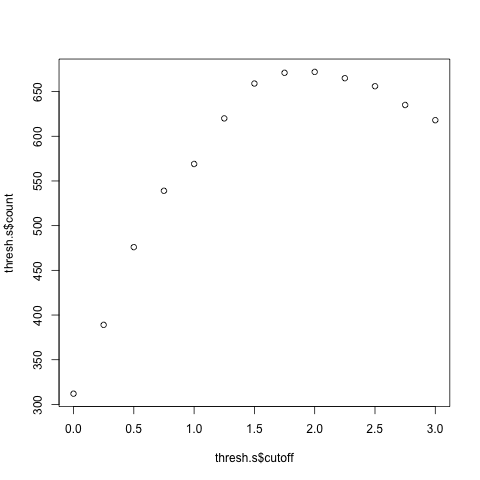

In [266]:
%%R
range = seq(0,3,0.25)
# Creates a range of numbers we are interested in for adjusted p values
thresh.s <- ldply(range, threshold)
# Applys the Threshold function we created above to the range of numbers we created above.

plot(thresh.s$count~thresh.s$cutoff)
# We can plot the threshold for base Mean value against the number of samples that will pass under this cutoff.
# We can see the optimum value to use here (here, 0.3)

In [267]:
%%R
group_by(DA, Trtmt,Month) %>%
    mutate(Total=sum(baseMean)) %>%
    filter(baseMean>=1.75) %>% 
    mutate(padj = p.adjust(pvalue,"BH")) %>% 
    write.csv("../../SeqData/l2fc.csv", row.names=FALSE)
# We take that differential abundance table we created above, and filter it to include only those samples 
# that had a baseMean value above the optimal cutoff we determined above.
# We then adjust the p values and save it as a csv.

In [3]:
%%R
l2fc<-read.csv("../../SeqData/l2fc.csv")

In [269]:
%%R
dim(l2fc[is.na(l2fc$padj)==TRUE,])/(dim(l2fc[is.na(l2fc$padj)==FALSE,])+dim(l2fc[is.na(l2fc$padj)==TRUE,]))
# Fraction of OTUs that were designated as "outliers" - way more in the fungi

[1] 0.3608247 0.5000000


In [6]:
%%R

cutoff = 1
FDR = 0.1

d = l2fc %>%
    group_by(Trtmt,Month)%>%
    mutate(Sig = ifelse(padj<FDR&l2FC>=cutoff,1,0))%>%
    mutate(Sig = ifelse(is.na(padj)==TRUE,0,Sig))%>%
    group_by(Trtmt,Month)%>%
    count(Trtmt,Month,Sig)%>%
    group_by(Trtmt,Month)%>%
    mutate(Fraction=n/sum(n))
mean(d$Fraction[d$Sig==1])

[1] 0.09268493


In [285]:
%%R -w 800 -h 700
# setting the image sizes, then making the figure...

d = l2fc %>%
    filter(padj<0.1)%>%
    group_by(Trtmt, Month) %>%
    mutate(relabund=baseMean/Total)

N= 500

#Phyla = levels(d$Phylum)

#NPhylum <- function (x){
#    m = c()
#    for (i in x){
#       L <- length(d$Phylum[d$Phylum==i])
#    if (L > N) m = c(m,i)
#        }
#        m
#    }
    
Classes = levels(d$Class)

NClass <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Class[d$Class==i])
    if (L > N) m = c(m,i)
        }
        m
    }

#Include<-as.factor(NPhylum(Phyla))
#d<-d[d$Phylum %in% Include,]
#d$Phylum<-factor(d$Phylum)   
    
Include<-as.factor(NClass(Classes))
d<-d[d$Class %in% Include,]
d$Class<-factor(d$Class) 
   
d$MonthName = ifelse(d$Month==2,"1 Month",(ifelse(d$Month==2.5, "1.5 Months","2 Months")))
d$MonthName = paste(d$MonthName)
# Creates a "strip" column of d with Months

max.l2FC = ddply(d, .(Class), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Class = factor(d$Class, max.l2FC[order(-max.l2FC$M),]$Class)
# takes our phylum column, and arranges it in order of our log2FoldChange values

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
  
    
    
p = ggplot(d, aes(x = Class, y = l2FC, fill = Class, size=relabund))
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.

p = p + facet_grid(~MonthName~Trtmt, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)"
                              #,range=c(3.5,9)
                              ,trans="log"
                             )
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Class")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2],"-fold change vs. soil",sep="")))
# sets the label for the y axes.


#p = p + scale_color_continuous(trans="log")    
p = p + scale_fill_discrete(guide="none")

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
    
p

Error in -max.l2FC$M : invalid argument to unary operator
In addition: Warning messages:
1: Stacking not well defined when ymin != 0 
2: Stacking not well defined when ymin != 0 
3: Stacking not well defined when ymin != 0 
4: Stacking not well defined when ymin != 0 
5: Stacking not well defined when ymin != 0 
6: Stacking not well defined when ymin != 0
Error in -max.l2FC$M : invalid argument to unary operator


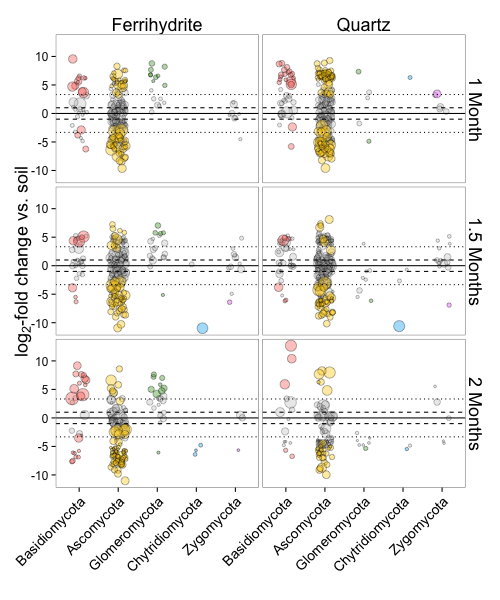

In [271]:
%%R -w 500 -h 600
# setting the image sizes, then making the figure...

d = l2fc %>%
    mutate(sig = ifelse(padj<0.1,1,0))%>%
    filter(Phylum != "Rozellomycota")%>%
    filter(Phylum != "unidentified")%>%
    filter(pvalue != 'NA')%>%
    group_by(Trtmt, Month) %>%
    mutate(relabund=baseMean/Total)


N= 5

Phyla = levels(d$Phylum)

NPhylum <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Phylum[d$Phylum==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NPhylum(Phyla))
d<-d[d$Phylum %in% Include,]
d$Phylum<-factor(d$Phylum)   
   
d$MonthName = ifelse(d$Month==2,"1 Month",(ifelse(d$Month==2.5, "1.5 Months","2 Months")))
d$MonthName = paste(d$MonthName)
# Creates a "strip" column of d with Months

max.l2FC = ddply(d, .(Phylum), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Phylum = factor(d$Phylum, max.l2FC[order(-max.l2FC$M),]$Phylum)
# takes our phylum column, and arranges it in order of our log2FoldChange values

#d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz"))

d$sig = as.factor(d$sig)
    
d.yes = d[d$sig==1,]
d.no = d[d$sig==0,]
    
p = ggplot()
# establishing our plot is based on the data table d, with our x being the phylum, and the y being log2fold change,
# and the colour being based on our "yes" or "no" column in the d data table.
    
p = p + geom_point(data=d.no, aes(x = Phylum, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.3, position = position_jitter(w = 0.20))
p = p + geom_point(data=d.yes, aes(x = Phylum, y = l2FC, fill = Phylum, size=relabund), shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
    
p = p + facet_grid(~MonthName~Trtmt, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns
    
p = p + scale_size_continuous("log(Relative\nAbundance)", trans="log")
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 18),
              strip.text.y = element_text(size = 18),
              axis.text.x = element_text(size = 14, angle = 45, hjust = 1),
              axis.title.x = element_text(size = 18),
              axis.text.y = element_text(size=12),
              axis.title.y = element_text(size = 18),
              legend.title = element_text(size=18),
              legend.text = element_text(size = 14),
              legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "")
# sets the label for the x axis. I think they didn't get the different colours.

#ylabel = expression(paste("", log[2],"-fold change",sep=""))
#ylabel =  str(c(ylabel,"\n vs. soil"))
#p = p + labs(y = ylabel)
p = p + labs(y = expression(paste(log[2],"-fold change vs. soil",sep="")))
# sets the label for the y axes.

p = p + theme(axis.title.y = element_text(vjust=0))
    
p = p + scale_fill_manual(values = c("grey","#FDD017","#F8766D","#00B0F6","#4AA02C","#E76BF3"), guide="none")

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
    
p
#levels(as.factor(d$MonthName))

In [272]:
%%R
ggsave(filename="DiffAbundITSMonthsNoCooks.jpg", plot=p ,width=5, height=6)

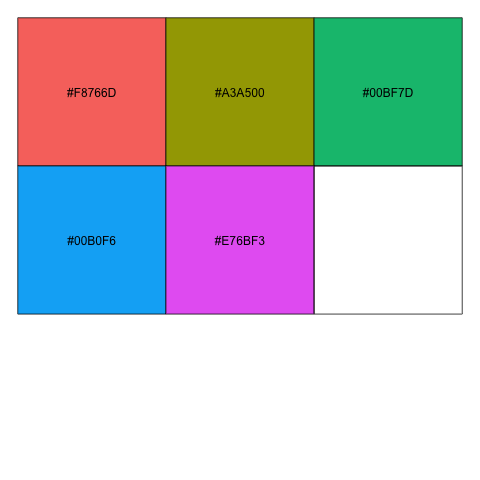

In [681]:
%%R
ggplotColours <- function(n=6, h=c(0, 360) +15){
  if ((diff(h)%%360) < 1) h[2] <- h[2] - 360/n
  hcl(h = (seq(h[1], h[2], length = n)), c = 100, l = 65)
}

scales:::show_col(ggplotColours(n=5))

In [317]:
%%R -w 800 -h 700
# setting the image sizes, then making the figure...

d = l2fc %>%
    filter(padj<0.1)%>%
    filter(Phylum=="Glomeromycota")%>%
    group_by(Trtmt, Month) %>%
    mutate(relabund=baseMean/Total)

Fams = levels(d$Family)

N=100

NFam <- function (x){
    m = c()
    for (i in x){
       L <- length(d$Family[d$Family==i])
    if (L > N) m = c(m,i)
        }
        m
    }

Include<-as.factor(NFam(Fams))
d<-d[d$Family %in% Include,]
d$Family<-factor(d$Family)  

d$MonthName = ifelse(d$Month==2,"2 Months",(ifelse(d$Month==2.5, "2.5 Months","3 Months")))
d$MonthName = paste(d$MonthName)
# Creates a "strip" column of d with Months

max.l2FC = ddply(d, .(Family), summarize, M = max(l2FC))
# makes a dataframe with the maximum value of log2Fold change for each phylum
d$Family = factor(d$Family, max.l2FC[order(-max.l2FC$M),]$Family)
# takes our phylum column, and arranges it in order of our log2FoldChange values

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))

p = ggplot(d, aes(x = Family, y = l2FC, fill = Family, size=relabund))

p = p + facet_grid(~MonthName~Trtmt, scales="free_x")
# saying we want it to present the data separately for our two variables (trtmt and month), in 2 columns

p = p + geom_point(shape = 21, alpha=0.4, position = position_jitter(w = 0.20))
# sets the points size and shape, and offsets them slightly (jitter) so they're not right on top of each other

p = p + scale_size_continuous("log(Relative\nAbundance)"
                              #,range=c(3.5,9)
                              ,trans="log"
                             )
    
p = p + geom_hline(y = 1, linetype=2)
p = p + geom_hline(y = -1, linetype=2)
p = p + geom_hline(y = 3.3219, linetype=3)
p = p + geom_hline(y = -3.3219, linetype=3)
p = p + geom_hline(y = 0.0, linetype=1)
# puts in horizontal lines at reference values

p = p + theme_bw()
# sets a theme

p = p + theme(strip.text.x = element_text(size = 20),
              strip.text.y = element_text(size = 20),
              axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1),
              axis.title.x = element_text(size = 16),
              axis.text.y = element_text(size=14),
              axis.title.y = element_text(size = 20),
              legend.title = element_text(size=20),
              legend.text = element_text(size = 14),
              #legend.position = "none",
              strip.background = element_blank())
# sets a bunch of visual paramters for the legend (none) and other text
    
p = p + labs(x = "Family")
# sets the label for the x axis. I think they didn't get the different colours.

p = p + labs(y = expression(paste("", log[2],"-fold change vs. soil",sep="")))
# sets the label for the y axes.


#p = p + scale_color_continuous(trans="log")    
p = p + scale_fill_discrete(guide="none")

p = p + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank())
# Gets rid of the default gridlines
    
p

Error in -max.l2FC$M : invalid argument to unary operator
In addition: There were 50 or more warnings (use warnings() to see the first 50)
Error in -max.l2FC$M : invalid argument to unary operator


###Of the total taxa, what fraction are the enriched ones?

In [318]:
%%R

cutoff=2

d.high = l2fc %>%
# Take the l2fc data frame,
    dplyr::filter(l2FC>cutoff, padj<=0.1)%>%
# Include only the rows where log2fold change is higher than 3, 
# We don't use the p value filter because we already filtered and it can't handle OTUs
# where there are extreme count outliers. In our case, this was because we merged our samples
# across lab reps, not because it was actually an outlier.
# Or, we can address this by not using the Cook's distance filtering step in DESeq.
# May leave it off, and then double check any results we want to interpret to see how affected.
    dplyr::group_by(Trtmt,Month) %>%
# Then, treating each month and mineral separately,
    dplyr::mutate(relabund=baseMean/Total)%>%
# Create a new column called relabund, which is the mean normalized count, divided by the total
# (total of those we selected, not of the whole dataset). 
    dplyr::group_by(Trtmt,Month,Species) %>%
# Then, using this data, still grouped by month and mineral, we further group it by phylum,
    dplyr::summarise(relabund=sum(relabund))
# And we tally up all the relative counts for each taxonomic group.

colnames(d.high) <- c("Trtmt","Month","Tax","relabund")
# Set the column names to generic so it's easier to change the order, etc.

mean.Abund = ddply(d.high, .(Tax), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
d.high$Tax = factor(d.high$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the phyla by abundance
d.high$Trtmt = ordered(d.high$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
# Order the treatments
d.high<-d.high[with(d.high, order(Tax)),]
# Sort the whole dataframe by this phylum order

abund=0.0005
d.high<-d.high %>%
    dplyr::filter(relabund>abund)
d.high$relabund
dim(d.high)

[1] 82  4


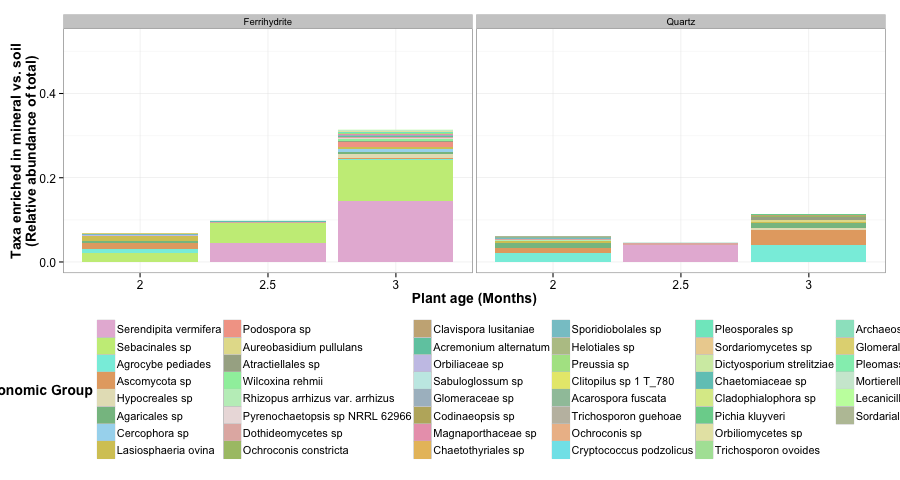

In [319]:
%%R -w 900

d.plot = d.high

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)
d.plot$Month <- as.factor(d.plot$Month)

p = ggplot(d.plot, aes(x=Month,y=relabund,fill = Tax))

p = p + facet_grid(~Trtmt)

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="Taxonomic Group", ncol = 6))

p = p + xlab("Plant age (Months)") + ylab("Taxa enriched in mineral vs. soil\n(Relative abundance of total)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11), legend.title=element_text(size=14), legend.position="bottom")

p

Sebacinales is mycorrhiza  
Sordariales reported EcM  
Serendipita vermifera reported to from EcM, but not confirmed.  
Hypocreales not EcM

## Of enriched taxa, breakdown?

In [192]:
%%R
d.high = l2fc %>%
    dplyr::mutate(Name=paste(Genus,Species))
head(d.high)

  Month  Trtmt    OTU  baseMean       l2FC        SE      pvalue Kingdom
1     2 Quartz  OTU_4 862.39193 -2.1312488 0.5873674 0.000285099   Fungi
2     2 Quartz  OTU_5 372.71979  0.3498253 0.9405550 0.709941270   Fungi
3     2 Quartz  OTU_9  92.05599  0.5461749 1.5478611 0.724195044   Fungi
4     2 Quartz OTU_64  62.05928 -2.6544751 1.4209796 0.061753705    <NA>
5     2 Quartz  OTU_8 407.91921 -5.4809834 2.5339017          NA   Fungi
6     2 Quartz OTU_23  92.46465 -2.7287960 1.1915381 0.022012870   Fungi
         Phylum           Class        Order            Family        Genus
1    Ascomycota  Eurotiomycetes   Eurotiales    Trichocomaceae  Penicillium
2    Ascomycota Sordariomycetes  Sordariales Lasiosphaeriaceae         <NA>
3 Basidiomycota  Agaricomycetes  Sebacinales      unidentified unidentified
4          <NA>            <NA>         <NA>              <NA>         <NA>
5    Ascomycota   Leotiomycetes   Helotiales   Rutstroemiaceae         <NA>
6 Rozellomycota    unidentified u

In [273]:
%%R

cutoff=2
abund=0.0005

d.high = l2fc %>%
    dplyr::filter(l2FC>cutoff, padj<=0.1)%>%
    dplyr::group_by(Trtmt,Month) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::mutate(name=ifelse(is.na(Genus),paste("unidentified"),ifelse(is.na(Species),paste(Genus,"sp."),paste(Species))))%>%
    dplyr::mutate(Tax=name)%>%
    dplyr::group_by(Trtmt,Month,Tax)%>%
    dplyr::summarise(totabund=sum(relabund))%>%
    dplyr::mutate(Tax=ifelse(is.na(Tax), "unidentified", paste(Tax)))%>%
    dplyr::group_by(Trtmt,Month,Tax)%>%
    dplyr::summarise(totabund=sum(totabund))

colnames(d.high) <- c("Trtmt","Month","Tax","relabund")
# Set the column names to generic so it's easier to change the order, etc.

mean.Abund = ddply(d.high, .(Tax), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
len = length(mean.Abund[order(-mean.Abund$M),]$Tax)
levs = c(mean.Abund[order(-mean.Abund$M),]$Tax[1],mean.Abund[order(-mean.Abund$M),]$Tax[3:len],mean.Abund[order(-mean.Abund$M),]$Tax[2])
d.high$Tax = factor(d.high$Tax, levels=levs)
#d.high$Tax = factor(d.high$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the phyla by abundance
d.high$Trtmt = ordered(d.high$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
# Order the treatments
d.high<-d.high[with(d.high, order(Tax)),]
# Sort the whole dataframe by this phylum order

d.plot = d.high
d.plot$Month=ifelse(d.plot$Month==2.0,1, ifelse(d.plot$Month==2.5,1.5,2))
d.plot$Month=as.factor(d.plot$Month)

head(d.plot)

Source: local data frame [6 x 4]
Groups: Trtmt, Month

         Trtmt Month                   Tax  relabund
1 Ferrihydrite   1.5 Serendipita vermifera 0.1836584
2 Ferrihydrite     2 Serendipita vermifera 0.4442617
3       Quartz   1.5 Serendipita vermifera 0.5741223
4 Ferrihydrite     1        Sebacinales sp 0.1105371
5 Ferrihydrite   1.5        Sebacinales sp 0.1756004
6 Ferrihydrite     2        Sebacinales sp 0.2910270


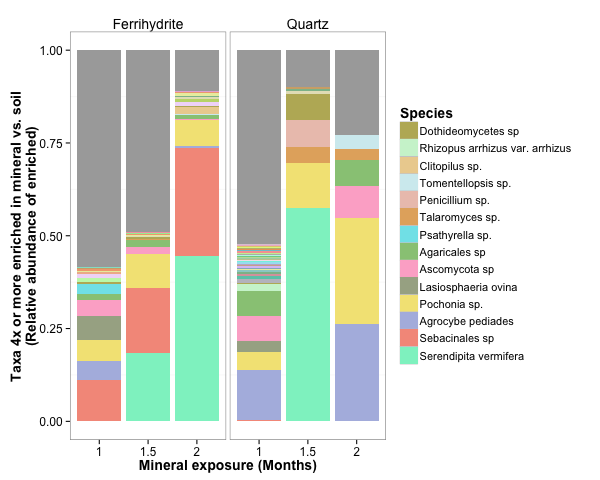

In [243]:
%%R -w 600

d.plot = d.high

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)
len = length(colors)
colors[len] = 'darkgrey'

d.plot$Month=ifelse(d.plot$Month==2.0,1, ifelse(d.plot$Month==2.5,1.5,2))
d.plot$Month=as.factor(d.plot$Month)

p = ggplot(d.plot, aes(x=Month, y=relabund, fill = Tax))

p = p + facet_grid(~Trtmt)

N=45
Breaks=factor(d.plot$Tax, d.plot[order(-d.plot$relabund),]$Tax)[1:N]
p = p + scale_fill_manual(values = colors, breaks=Breaks)

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="Species", ncol = 1, reverse=TRUE))

p = p + xlab("Mineral exposure (Months)") + ylab("Taxa 4x or more enriched in mineral vs. soil\n(Relative abundance of enriched)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11), legend.title=element_text(size=14), legend.position="right")
p = p + theme(strip.background = element_blank(),strip.text = element_text(size=14), panel.grid.major= element_blank())

p

In [274]:
%%R
ggsave(filename="DAITSSpeciesCutoff2.jpg", p, width=6, height=5)

## Total OTUs enriched

In [322]:
%%R

cutoff = 3.3

d.OTU = l2fc %>%
# Take the l2fc data frame,
    dplyr::filter(l2FC>cutoff)%>%
# Include only the rows where log2fold change is higher than 3.
    dplyr::group_by(Trtmt,Month) %>%
# Then, treating each month and mineral separately,
    dplyr::mutate(relabund=baseMean/sum(baseMean))

#colnames(d.high) <- c("Trtmt","Month","Tax","relabund")
# Set the column names to generic so it's easier to change the order, etc.

mean.Abund = ddply(d.OTU, .(OTU), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
d.OTU$OTU = factor(d.OTU$OTU, levels=mean.Abund[order(-mean.Abund$M),]$OTU)
# Order the phyla by abundance
d.OTU<-d.OTU[with(d.OTU, order(OTU)),]
# Sort the whole dataframe by this order

In [323]:
%%R
cutoff=0.005
d.OTU.common<-d.OTU %>%
    dplyr::filter(relabund>cutoff)
d.OTU.common$relabund
dim(d.OTU.common)

[1] 121  17


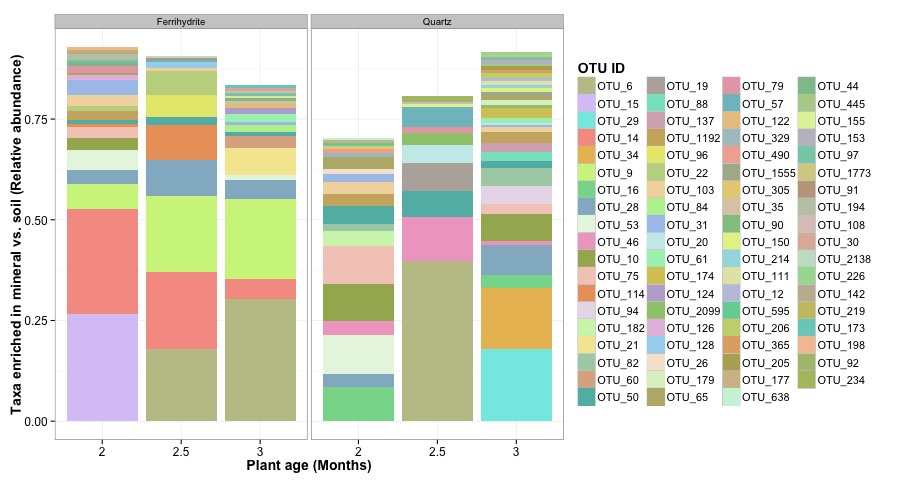

In [324]:
%%R -w 900

d.plot = d.OTU.common

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$OTU)), color_space = hcl_presets$pastel)
d.plot$Month <- as.factor(d.plot$Month)

p = ggplot(d.plot, aes(x=Month,y=relabund,fill = OTU))

p = p + facet_wrap(~Trtmt)

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="OTU ID", ncol = 4))

p = p + xlab("Plant age (Months)") + ylab("Taxa enriched in mineral vs. soil (Relative abundance)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11))
p = p + theme(legend.title=element_text(size=14))

p

OTU_15 is Hypocreales
OTU_6 and OTU_9 are both Sebacinales
OTU_14 hard to say more than Asco - Dothidiomycetes, Pleiosporales
OTU_28 Pochonia is a nematode parasite!
OTU_114 uncultured fungus clone prairie soil
OTU_5 is family Lasiosphaeriaceae, from Sordariomycetes

In [315]:
%%R
tax_table(physeq)["OTU_13"]

Taxonomy Table:     [1 taxa by 8 taxonomic ranks]:
       Kingdom Phylum       Class             Order            Family Genus
OTU_13 "Fungi" "Ascomycota" "Sordariomycetes" "Coniochaetales" NA     NA   
       Species Rank1
OTU_13 NA      NA   


In [330]:
#Who is... 
!grep -A -2 OTU_28 ../../SeqData/ITS.otus.fasta

>OTU_28
CAACCCTCAAGCCCCAGCGGTTTGGTGTTGGGGACCGGCGAGTACAGAGGCTTTGGGGACTTGTCCCCCTTCCCTCGGCG
CCGCCCCCGAAATGAATTGGCGGTCTCGTCGCGGCCTCCTCTGCGTAGTAGCACAACCTCGCATCAGGAGCGCGGCGCGG
CCACTGCCGTAAAACGCCCAACTTTTTTTAAG
>OTU_29
CACCACTCAAGCCTCGCTTGGTATTGGGCGACGCGGTACGCCGCGCGCCCCAAATCGACCGGCTGGGTCGACCGTCCCCT
CAGCGTTGTGGCAACTATTCGCTAAAGGGTGTCGCGGTCGGTCACGCCGTAAAACAAGACCTCATTTCTAA
>OTU_30
CAACCATCAAGCCCCTGTGCTTGTGTTGGAGCCCTGCGGCTGCCGCAGGCTCCCAAACCCAGTGGCGGGCTCGTCGTCGT
ACCGAGTGCAGTAAATTTACCACGCTCAGGGCACGCGACGGGTGACCGGCCGTAAAACCCCCACTTCTCAA
>OTU_31
CAACCATCAGGCCCCCGGGCCCGTGTTGGGGCACCGCGCGCCAGCCGCGCAGGCCCTCAAAACCAGTGGCGGGCTCGCTG
TCGCACCGAGCGTAGTAACACATCTCGCTCCGGGCGCGCGGCGGGCGCTTGCCGTAAAACACCCCCCTTCTCAA
>OTU_32
AAACCCTCAAGCACTGCTTGGTTATGGGTGCCTGTCGCGCCCCCCGCGCGCGACTCACCTCAAATCCATTGGCGGCCCCC
ACGTCGGCTCCGAGCGCAGCAGAAACGCGGACTCGGTGCCCGGCGGAGAGGCTCCCAGAAGCCAACCCCACAG
>OTU_33
ACAACCTCAGCCAAGTTTTTTGTCGCCTCTGGCGCGGAAAGCAACAGCTGGATTTGAGCAAAGTCCCTTGGGATTTCAAT
TCGACGACCTTCGGGGAGCAATTGAGCCGTGAGGGATGCTTGAAATACAGGTTCGGGCT

In [326]:
%%R
head(l2fc)

  Month  Trtmt    OTU  baseMean       l2FC        SE      pvalue Kingdom
1     2 Quartz  OTU_4 862.39193 -2.1312488 0.5873674 0.000285099   Fungi
2     2 Quartz  OTU_5 372.71979  0.3498253 0.9405550 0.709941270   Fungi
3     2 Quartz  OTU_9  92.05599  0.5461749 1.5478611 0.724195044   Fungi
4     2 Quartz OTU_64  62.05928 -2.6544751 1.4209796 0.061753705    <NA>
5     2 Quartz  OTU_8 407.91921 -5.4809834 2.5339017 0.030536505   Fungi
6     2 Quartz OTU_23  92.46465 -2.7287960 1.1915381 0.022012870   Fungi
         Phylum           Class        Order            Family        Genus
1    Ascomycota  Eurotiomycetes   Eurotiales    Trichocomaceae  Penicillium
2    Ascomycota Sordariomycetes  Sordariales Lasiosphaeriaceae         <NA>
3 Basidiomycota  Agaricomycetes  Sebacinales      unidentified unidentified
4          <NA>            <NA>         <NA>              <NA>         <NA>
5    Ascomycota   Leotiomycetes   Helotiales   Rutstroemiaceae         <NA>
6 Rozellomycota    unidentified u

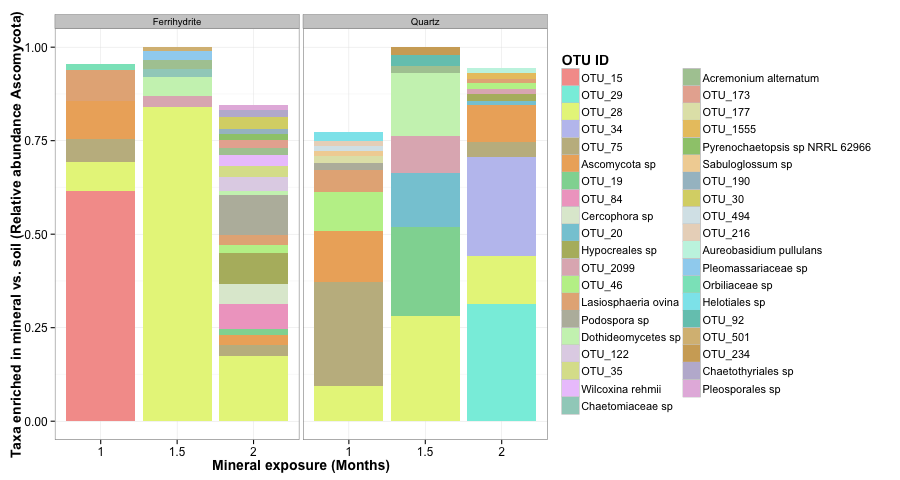

In [639]:
%%R -w 900

cutoff=2

d.high = l2fc %>%
    dplyr::filter(l2FC>cutoff, Phylum=="Ascomycota", padj<=0.1)
d.high$Species = ifelse(is.na(d.high$Species)==TRUE, paste(d.high$OTU), paste(d.high$Species))
d.high = d.high %>%
    dplyr::group_by(Trtmt,Month) %>%
    dplyr::filter(sum(baseMean)>0) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
    dplyr::group_by(Trtmt,Month,Species) %>%
    dplyr::summarise(relabund=sum(relabund))

colnames(d.high) <- c("Trtmt","Month","Tax","relabund")
# Set the column names to generic so it's easier to change the order, etc.

mean.Abund = ddply(d.high, .(Tax), summarize, M = mean(relabund))
# Calculate the phyla's mean abundances
d.high$Tax = factor(d.high$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the phyla by abundance
d.high$Trtmt = ordered(d.high$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
# Order the treatments
d.high<-d.high[with(d.high, order(Tax)),]
# Sort the whole dataframe by this phylum order

abund=0.01
d.high<-d.high %>%
    dplyr::filter(relabund>abund)
d.high$relabund
dim(d.high)

d = d.high


scheme <- iwanthue()
colors = scheme$hex(length(unique(d$Tax)), color_space = hcl_presets$pastel)
d$Month=ifelse(d$Month==2.0,1, ifelse(d$Month==2.5,1.5,2))
d$Month <- as.factor(d$Month)

p = ggplot(d, aes(x=Month,y=relabund,fill = Tax))

p = p + facet_wrap(~Trtmt)

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.90)

p = p + guides(fill = guide_legend(title="OTU ID", ncol = 2))

p = p + xlab("Mineral exposure (Months)") + ylab("Taxa enriched in mineral vs. soil (Relative abundance Ascomycota)")

p = p + theme_bw()

p = p + theme(axis.title = element_text(size=14,face="bold"))
p = p + theme(axis.text = element_text(size=12,))
p = p + theme(legend.text=element_text(size=11))
p = p + theme(legend.title=element_text(size=14))

p

In [370]:
%%R
head(l2fc)

  Month  Trtmt    OTU  baseMean       l2FC        SE      pvalue Kingdom
1     2 Quartz  OTU_4 862.39193 -2.1312488 0.5873674 0.000285099   Fungi
2     2 Quartz  OTU_5 372.71979  0.3498253 0.9405550 0.709941270   Fungi
3     2 Quartz  OTU_9  92.05599  0.5461749 1.5478611 0.724195044   Fungi
4     2 Quartz OTU_64  62.05928 -2.6544751 1.4209796 0.061753705    <NA>
5     2 Quartz  OTU_8 407.91921 -5.4809834 2.5339017 0.030536505   Fungi
6     2 Quartz OTU_23  92.46465 -2.7287960 1.1915381 0.022012870   Fungi
         Phylum           Class        Order            Family        Genus
1    Ascomycota  Eurotiomycetes   Eurotiales    Trichocomaceae  Penicillium
2    Ascomycota Sordariomycetes  Sordariales Lasiosphaeriaceae         <NA>
3 Basidiomycota  Agaricomycetes  Sebacinales      unidentified unidentified
4          <NA>            <NA>         <NA>              <NA>         <NA>
5    Ascomycota   Leotiomycetes   Helotiales   Rutstroemiaceae         <NA>
6 Rozellomycota    unidentified u

###Making pos/neg figure

In [279]:
%%R
head(l2fc)

  Month        Trtmt    OTU   baseMean       l2FC        SE       pvalue
1     2 Ferrihydrite  OTU_4 1297.57326 -3.1467189 0.7844648 6.038691e-05
2     2 Ferrihydrite  OTU_5  553.37843  0.2582756 0.9514190 7.860345e-01
3     2 Ferrihydrite  OTU_9  613.57922  3.6798266 1.1925579 2.031019e-03
4     2 Ferrihydrite OTU_64   87.88554 -4.0376281 1.2952512 1.825437e-03
5     2 Ferrihydrite  OTU_8  463.21355 -3.5430718 2.4113943           NA
6     2 Ferrihydrite OTU_23  193.24632 -0.7508587 1.0522274 4.754809e-01
  Kingdom        Phylum           Class        Order            Family
1   Fungi    Ascomycota  Eurotiomycetes   Eurotiales    Trichocomaceae
2   Fungi    Ascomycota Sordariomycetes  Sordariales Lasiosphaeriaceae
3   Fungi Basidiomycota  Agaricomycetes  Sebacinales      unidentified
4    <NA>          <NA>            <NA>         <NA>              <NA>
5   Fungi    Ascomycota   Leotiomycetes   Helotiales   Rutstroemiaceae
6   Fungi Rozellomycota    unidentified unidentified      unide

In [282]:
%%R

FDR=0.1

d = l2fc
PhylumOrder <- c("Glomeromycota","Basidiomycota","Zygomycota","Ascomycota","Chytridiomycota","Rozellomycota")

d = d %>%
    filter(Phylum!="unidentified")%>%
    filter(Month==3)%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Resp = ifelse((l2FC >= 0),1,ifelse((l2FC<0),-1,0)))%>%
    mutate(Signif = ifelse((padj <= FDR),1,0))%>%
    mutate(Signif = ifelse(is.na(padj)==TRUE,0,Signif))%>%
    mutate(RespSignif = ifelse(Resp==-1&Signif==1,"NegSignif",
                               ifelse(Resp==1&Signif==1,"PosSignif",
                                      ifelse(Resp==-1&Signif==0,"NegNS",
                                             ifelse(Resp==1&Signif==0,"PosNS","")))))%>%
    group_by(Phylum,Trtmt,Resp,RespSignif)%>%
    summarize(n=n())%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Fract = Resp*n/sum(n))%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Sum = sum(n)) %>%
    mutate(Shade = log(Sum))%>%
    arrange(Phylum)
d

Source: local data frame [34 x 8]
Groups: Phylum, Trtmt

          Phylum        Trtmt Resp RespSignif   n       Fract Sum    Shade
1     Ascomycota Ferrihydrite   -1      NegNS  86 -0.31617647 272 5.605802
2     Ascomycota Ferrihydrite   -1  NegSignif  72 -0.26470588 272 5.605802
3     Ascomycota Ferrihydrite    1      PosNS 107  0.39338235 272 5.605802
4     Ascomycota Ferrihydrite    1  PosSignif   7  0.02573529 272 5.605802
5     Ascomycota       Quartz   -1      NegNS  98 -0.45370370 216 5.375278
6     Ascomycota       Quartz   -1  NegSignif  29 -0.13425926 216 5.375278
7     Ascomycota       Quartz    1      PosNS  83  0.38425926 216 5.375278
8     Ascomycota       Quartz    1  PosSignif   6  0.02777778 216 5.375278
9  Basidiomycota Ferrihydrite   -1      NegNS  14 -0.24561404  57 4.043051
10 Basidiomycota Ferrihydrite   -1  NegSignif   8 -0.14035088  57 4.043051
..           ...          ...  ...        ... ...         ... ...      ...


In [310]:
%%R
d = l2fc

levels(as.factor(d$Month))

[1] "2"   "2.5" "3"  


In [308]:
%%R

FDR=0.1

d = l2fc
PhylumOrder <- c("Glomeromycota","Basidiomycota","Zygomycota","Ascomycota","Chytridiomycota","Rozellomycota")

d = d %>%
    filter(Phylum!="unidentified")%>%
    filter(Month==2)%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Resp = ifelse((l2FC >= 0),1,ifelse((l2FC<0),-1,0)))%>%
    mutate(Signif = ifelse((padj <= FDR),1,0))%>%
    mutate(Signif = ifelse(is.na(padj)==TRUE,0,Signif))%>%
    mutate(RespSignif = ifelse(Resp==-1&Signif==1,"NegSignif",
                               ifelse(Resp==1&Signif==1,"PosSignif",
                                      ifelse(Resp==-1&Signif==0,"NegNS",
                                             ifelse(Resp==1&Signif==0,"PosNS","")))))%>%
    group_by(Phylum,Trtmt,Resp,RespSignif)%>%
    summarize(n=n())%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Fract = Resp*n/sum(n))%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Sum = sum(n)) %>%
    mutate(Shade = log(Sum))%>%
    arrange(Phylum)

d.pos = subset(d,Resp>0)
d.neg = subset(d,Resp<0)
d.pos$Phylum <- factor(d.pos$Phylum, levels = PhylumOrder, ordered=TRUE)
d.neg$Phylum <- factor(d.neg$Phylum, levels = PhylumOrder, ordered=TRUE)


p = ggplot()
p = p + geom_bar(data=d.pos, aes(x=Phylum,y=Fract,fill=RespSignif,alpha=Shade),stat="identity", position="stack") 
p = p + geom_bar(data=d.neg, aes(x=Phylum,y=Fract,fill=RespSignif,alpha=Shade),stat="identity", position="stack")
p = p + scale_x_discrete(limits=PhylumOrder)
p = p + facet_grid(~Trtmt)
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(size = 12, angle=45, hjust=1))
p = p + theme(axis.text.y = element_text(size = 12))
p = p + scale_fill_manual(values=c("lightpink","red","steelblue2","midnightblue"))
p = p + scale_alpha_continuous(range=c(0.3, 1),guide=F)
p = p + ylab("Fraction of taxa higher or lower\nin relative abundance vs. soil") + xlab("")
p = p + ylim(c(-1,1))
p = p + theme(strip.text = element_text(size = 15),
              axis.title.y = element_text(size = 16, face = "bold"),
              legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
p = p + geom_hline(y = 0.0, linetype=1)

p

Error in eval(expr, envir, enclos) : 
  incompatible types, expecting a numeric vector
In addition: Warning messages:
1: Stacking not well defined when ymin != 0 
2: Stacking not well defined when ymin != 0
Error in eval(expr, envir, enclos) : 
  incompatible types, expecting a numeric vector


In [284]:
%%R
ggsave(filename="DAITSredblue.jpg", plot=p ,width=5, height=5)

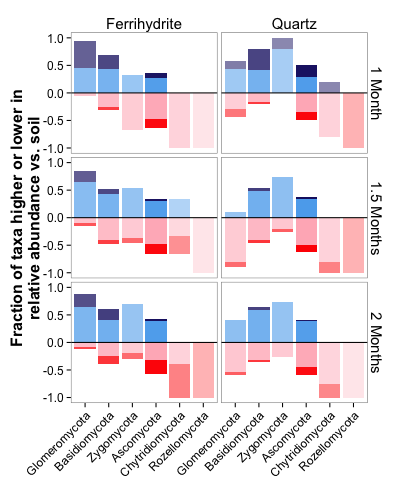

In [360]:
%%R -h 500 -w 400

FDR = 0.1

d = l2fc
PhylumOrder <- c("Glomeromycota","Basidiomycota","Zygomycota","Ascomycota","Chytridiomycota","Rozellomycota")

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))

d = l2fc %>%
    filter(Phylum %in% PhylumOrder)%>%
    #filter(Month==3)%>%
    group_by(Phylum,Trtmt,Month)%>%
    mutate(Resp = ifelse((l2FC >= 0),1,ifelse((l2FC<0),-1,0)))%>%
    mutate(Signif = ifelse(is.na(padj)==TRUE,0,ifelse((padj >= FDR),0,1)))%>%
    mutate(RespSignif = ifelse(Resp==-1&Signif==1,"NegSignif",
                               ifelse(Resp==1&Signif==1,"PosSignif",
                                      ifelse(Resp==-1&Signif==0,"NegNS",
                                             ifelse(Resp==1&Signif==0,"PosNS","")))))%>%
    group_by(Phylum,Trtmt,Month,Resp,RespSignif)%>%
    summarize(n=n())%>%
    group_by(Phylum,Trtmt,Month)%>%
    mutate(Fract = Resp*n/sum(n))%>%
    group_by(Phylum,Trtmt,Month)%>%
    mutate(Sum = sum(n))%>%
    mutate(Shade = log(Sum))%>%
    arrange(Phylum)

d$MonthName = ifelse(d$Month==2,"1 Month",(ifelse(d$Month==2.5, "1.5 Months","2 Months")))

d.pos = subset(d,Resp>0)
d.neg = subset(d,Resp<0)
d.pos$Phylum <- factor(d.pos$Phylum, levels = PhylumOrder, ordered=TRUE)
d.neg$Phylum <- factor(d.neg$Phylum, levels = PhylumOrder, ordered=TRUE)

p = ggplot()
p = p + geom_bar(data=d.pos, aes(x=Phylum,y=Fract,fill=RespSignif,alpha=Shade),stat="identity", position="stack") 
p = p + geom_bar(data=d.neg, aes(x=Phylum,y=Fract,fill=RespSignif,alpha=Shade),stat="identity", position="stack")
p = p + scale_x_discrete(limits=PhylumOrder)
p = p + facet_grid(~MonthName~Trtmt)
p = p + theme_bw()
p = p + theme(axis.text.x = element_text(size = 12, angle=45, hjust=1))
p = p + theme(axis.text.y = element_text(size = 12))
p = p + scale_fill_manual(values=c("lightpink","red","steelblue2","midnightblue"))
p = p + scale_alpha_continuous(range=c(0.3, 1),guide=F)
p = p + ylab("Fraction of taxa higher or lower in\nrelative abundance vs. soil") + xlab("")
p = p + ylim(c(-1,1))
p = p + theme(strip.text = element_text(size = 15),
              axis.title.y = element_text(size = 16, face = "bold"),
              legend.position = "none",
              strip.background = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank())
p = p + geom_hline(y = 0.0, linetype=1)

p

In [363]:
%%R
ggsave(filename="DAITSredblue3months.jpg", plot=p ,width=5, height=7)

In [16]:
%%R
FDR=0.1

d = l2fc
PhylumOrder <- c("Glomeromycota","Basidiomycota","Zygomycota","Ascomycota","Chytridiomycota","Rozellomycota")

d = d %>%
    filter(Phylum!="unidentified")%>%
    filter(Month==3)%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Resp = ifelse((l2FC > 0),1,ifelse((l2FC<0),-1,0)))%>%
    mutate(Signif = ifelse((padj < FDR),1,0))%>%
    mutate(RespSignif = ifelse(Resp==-1&Signif==1,"NegSignif",
                               ifelse(Resp==1&Signif==1,"PosSignif",
                                      ifelse(Resp==-1&Signif==0,"NegNS",
                                             ifelse(Resp==1&Signif==0,"PosNS","")))))%>%
    group_by(Phylum,Trtmt,Resp,RespSignif)%>%
    summarize(n=n())%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Fract = Resp*n/sum(n))%>%
    group_by(Phylum,Trtmt)%>%
    mutate(Sum = sum(n)) %>%
    mutate(Shade = log(Sum))%>%
    arrange(Phylum)
d[d$Phylum=="Glomeromycota",]

Source: local data frame [8 x 8]
Groups: Phylum, Trtmt

         Phylum        Trtmt Resp RespSignif  n       Fract Sum    Shade
1 Glomeromycota Ferrihydrite   -1      NegNS  2 -0.06060606  33 3.496508
2 Glomeromycota Ferrihydrite   -1  NegSignif  2 -0.06060606  33 3.496508
3 Glomeromycota Ferrihydrite    1      PosNS 15  0.45454545  33 3.496508
4 Glomeromycota Ferrihydrite    1  PosSignif 14  0.42424242  33 3.496508
5 Glomeromycota       Quartz   -1      NegNS  7 -0.46666667  15 2.708050
6 Glomeromycota       Quartz   -1  NegSignif  2 -0.13333333  15 2.708050
7 Glomeromycota       Quartz    1      PosNS  4  0.26666667  15 2.708050
8 Glomeromycota       Quartz    1  PosSignif  2  0.13333333  15 2.708050


In [306]:
%%R
subset(l2fc,l2fc$Class=="Eurotiomycetes")[,c(1,2,3,4,5,10,11,12,15)]

     Month        Trtmt      OTU    baseMean          l2FC          Class
1      2.0       Quartz    OTU_4  862.391927  -2.131248753 Eurotiomycetes
8      2.0       Quartz    OTU_2  762.843400  -6.175688310 Eurotiomycetes
17     2.0       Quartz  OTU_172    6.452627  -5.846483564 Eurotiomycetes
26     2.0       Quartz OTU_2099    7.502159  -2.635630193 Eurotiomycetes
38     2.0       Quartz   OTU_86   29.579029  -0.010174315 Eurotiomycetes
58     2.0       Quartz   OTU_37  174.579191  -5.567469817 Eurotiomycetes
66     2.0       Quartz   OTU_47  167.657877   0.872917237 Eurotiomycetes
83     2.0       Quartz   OTU_27   71.439981  -6.149477413 Eurotiomycetes
87     2.0       Quartz   OTU_20   13.374934   1.917463871 Eurotiomycetes
93     2.0       Quartz   OTU_68   89.808457  -0.600039873 Eurotiomycetes
97     2.0       Quartz  OTU_396   19.760418   1.386171066 Eurotiomycetes
117    2.0       Quartz  OTU_174    2.099691  -4.471408871 Eurotiomycetes
134    2.0       Quartz  OTU_599   11.

In [310]:
%%R
subset(l2fc,l2fc$OTU=="OTU_2")[,c(1,2,3,4,5,10,11,12,15)]

     Month        Trtmt   OTU  baseMean      l2FC          Class      Order
8      2.0       Quartz OTU_2  762.8434 -6.175688 Eurotiomycetes Eurotiales
563    2.0 Ferrihydrite OTU_2 1041.3630 -6.551408 Eurotiomycetes Eurotiales
1050   2.5       Quartz OTU_2 3857.4686 -3.045371 Eurotiomycetes Eurotiales
1725   2.5 Ferrihydrite OTU_2 2168.1371 -3.762978 Eurotiomycetes Eurotiales
2283   3.0       Quartz OTU_2 5103.9785  2.124629 Eurotiomycetes Eurotiales
2742   3.0 Ferrihydrite OTU_2 2152.1098 -2.253725 Eurotiomycetes Eurotiales
             Family    Total
8    Trichocomaceae 17170.74
563  Trichocomaceae 29116.03
1050 Trichocomaceae 30939.56
1725 Trichocomaceae 22777.47
2283 Trichocomaceae 55409.49
2742 Trichocomaceae 36753.75


### AMF EMF response to minerals

In [57]:
%%R
EMF = read.csv("../../SeqData/EMF.txt",quote ="",header=FALSE)
l = length(EMF)
m = c()
for (i in c(1:l)) {
    m = c(m,substring(paste((EMF[[i]])),4,100))
}

In [75]:
%%R
d = l2fc %>%
    mutate(EMFv =ifelse((Genus %in% m | Family %in% m), "EMF",
                ifelse(Phylum=="Glomeromycota","AMF","Other")))
d$EMFv[is.na(d$EMFv)]="Other"
d.MF = d %>%
    dplyr::group_by(Trtmt,Month) %>%
    dplyr::mutate(relabund=baseMean/sum(baseMean))%>%
#    dplyr::filter(EMFv == "AMF" | EMFv == "EMF" )%>%
    dplyr::select(Month,Trtmt,Family,l2FC,EMFv,relabund,padj)

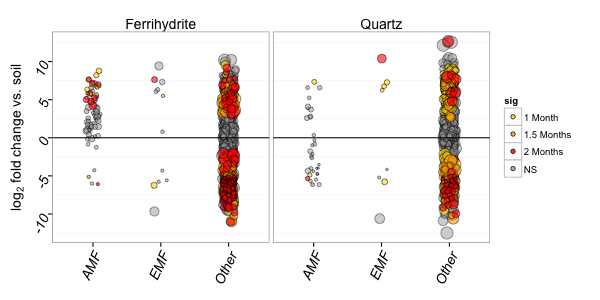

In [80]:
%%R -w 600 -h 300

d = d.MF

d$Trtmt = ordered(d$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction"))
d$sig = ifelse(d$padj<=0.1,"yes","NS")
d$sig = ifelse(is.na(d$padj),"NS",paste(d$sig))
d$Month = as.factor(d$Month)
d$Month = ifelse(d$Month==2,"1 Month",(ifelse(d$Month==2.5, "1.5 Months","2 Months")))

d.yes = d[d$sig=="yes",]
d.no = d[d$sig=="NS",]

p = ggplot(d, aes(x=Genus, y=l2FC))

p = p + geom_point(data=d.no, aes(x = EMFv, y = l2FC, fill = sig, size=relabund), shape = 21, alpha=0.5, position = position_jitter(w = 0.10))
p = p + geom_point(data=d.yes, aes(x = EMFv, y = l2FC, fill = Month, size=relabund), shape = 21, alpha=0.6, position = position_jitter(w = 0.10))

p = p + scale_size_continuous("log(Relative\nAbundance)",trans="log",guide="none")
p = p + scale_fill_manual(values=c("gold","orange","red","darkgrey"))
p = p + facet_grid(~Trtmt)
p = p + geom_hline(aes(yintercept=0))
p = p + theme_bw()
p = p + labs(y = expression(paste("", log[2]," fold change vs. soil",sep="")))
p = p + theme(axis.text = element_text(angle=65,hjust=1, size=14, face="italic"),
            strip.background = element_blank(),
            strip.text = element_text(size=14),
             axis.title.x = element_blank(),
             axis.title.y = element_text(size=14),
             panel.grid.major = element_blank())
p